In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.datasets import make_classification

from collections import Counter


In [5]:
dfgos = pd.read_csv('cellinedata/genedata/goidsdefs.csv')
def getGoDesc(go_id):
    result = dfgos[dfgos['go_id'] == go_id]    
    if not result.empty:
        name = result['name_1006'].values[0]
        if pd.isna(name):
            return 'NONE'
        else:
            return name.lower().replace(' ', '_')   # Convert to lowercase and replace spaces with underscores
    else:
        return 'NOGO'
dfgos.head(2)
chipseqfile='chipseq/BREAST_CHIPSEQ.csv'
CELLLINE='ACH-000768'
CELLINENAME='MDA-MB-231'
CELLTISSUE='BREAST'
DRUG='UF010'
seqfile='rnaseq/UF010.csv'
genefile='cellinedata/MDA-MB-231.csv'
DRUGS=['YX6862','YX968','UF010']
DRUGS=['UF010']

In [10]:
for thedrug in DRUGS:
    DRUG=thedrug
    seqfile='rnaseq/'+thedrug+'.csv'
    Label='PROTAC '+DRUG
    barcolor='paleturquoise'
    cfcolor='Blues'
    ML='RandomForest'
    if DRUG=='UF010':
        Label='HDACi UF010'
        barcolor='pink'
        cfcolor='Reds'
    if DRUG=='YX6862':
        ML='Graph neural network'
        cfcolor='Greens'
    print('-----------------------------------------------')
    print(DRUG)
    print('')
    df_seqfile = pd.read_csv(seqfile)
    df_seqfile['upr'] = df_seqfile['regulated'].apply(lambda x: 1 if x == 'up' else 0)
    df_seqfile['downr'] = df_seqfile['regulated'].apply(lambda x: 1 if x == 'down' else 0)
    df_genefile = pd.read_csv(genefile)
    merged_df = pd.merge(df_seqfile, df_genefile, on='gene', how='left') 
    merged_df.fillna(0, inplace=True)
    merged_df.drop('go_id', axis=1, inplace=True)
    merged_df = merged_df.rename(columns={'GO_IDS': 'go_id'})
    
    df_chipseqfile = pd.read_csv(chipseqfile)
    merged_df = pd.merge(merged_df, df_chipseqfile, on='gene', how='left') 
    merged_df.fillna(0, inplace=True)
    
    
    data=merged_df.copy()
    data['go_id'] = data['go_id'].astype(str)
    all_go_ids = ' '.join(data['go_id']).split()  # Join and split the GO IDs into a list
    go_id_counts = Counter(all_go_ids)  # Count occurrences of each GO ID
    common_go_ids = [go_id for go_id, count in go_id_counts.items() if count > 10]
    print('common_go_ids',len(common_go_ids))
    
    new_columns = {}
    for go_id in common_go_ids:    
        new_columns[getGoDesc(go_id)] = data['go_id'].apply(lambda x: x.split().count(go_id))
    
    len(new_columns)
    new_columns_df = pd.DataFrame(new_columns) 
    final_data = pd.concat([data, new_columns_df], axis=1)
    final_data.columns = final_data.columns.str.replace(r'[\[\]<>]', '', regex=True)
    features = final_data.drop(["gene", "go_id", 'upr', 'downr', 'regulated'], axis=1)
    print('final_data',features.shape)

    duplicated_columns = features.columns[features.columns.duplicated()]
    if len(duplicated_columns) > 0:
        print(f"Duplicated columns in features: {duplicated_columns}")
        features = features.loc[:, ~features.columns.duplicated()]
    else:
        print("No duplicated columns in features.")
    
   
    target = data["upr"] 

-----------------------------------------------
UF010

common_go_ids 3200
final_data (20798, 3158)
Duplicated columns in features: Index(['methylation'], dtype='object')


In [11]:
 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [12]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVC': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Initialize an empty list to collect metrics
metrics_list = []

# Train and evaluate each model
for model_name, model in models.items():
    try:
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC-ROC
    
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_prob)
    
        # Append the results as a dictionary
        metrics_list.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC-ROC': auc_roc
        })
        print("done",model_name)
    except:
        print('oops',model_name)
        
# Convert the list of dictionaries into a DataFrame
metrics = pd.DataFrame(metrics_list)

# Display metrics
print(metrics)


done Random Forest
done Decision Tree


C:\Users\1G6652897\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


done SVC


C:\Users\1G6652897\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


done XGBoost


C:\Users\1G6652897\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


done Logistic Regression
done K-Nearest Neighbors
done Naive Bayes
                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0        Random Forest  0.943510   0.865385  0.164835  0.276923  0.716790
1        Decision Tree  0.897837   0.232394  0.241758  0.236984  0.579431
2                  SVC  0.934375   0.000000  0.000000  0.000000  0.558908
3              XGBoost  0.939423   0.714286  0.128205  0.217391  0.706013
4  Logistic Regression  0.929327   0.080000  0.007326  0.013423  0.556782
5  K-Nearest Neighbors  0.931490   0.285714  0.029304  0.053156  0.581143
6          Naive Bayes  0.428846   0.082572  0.761905  0.148997  0.586069


C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\4107831651.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=metrics, palette='viridis')
C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\4107831651.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Precision', y='Model', data=metrics, palette='coolwarm')
C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\4107831651.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Recall', y='Model', data=metrics, palette='coolwarm')
C:\Users\1G6652897\

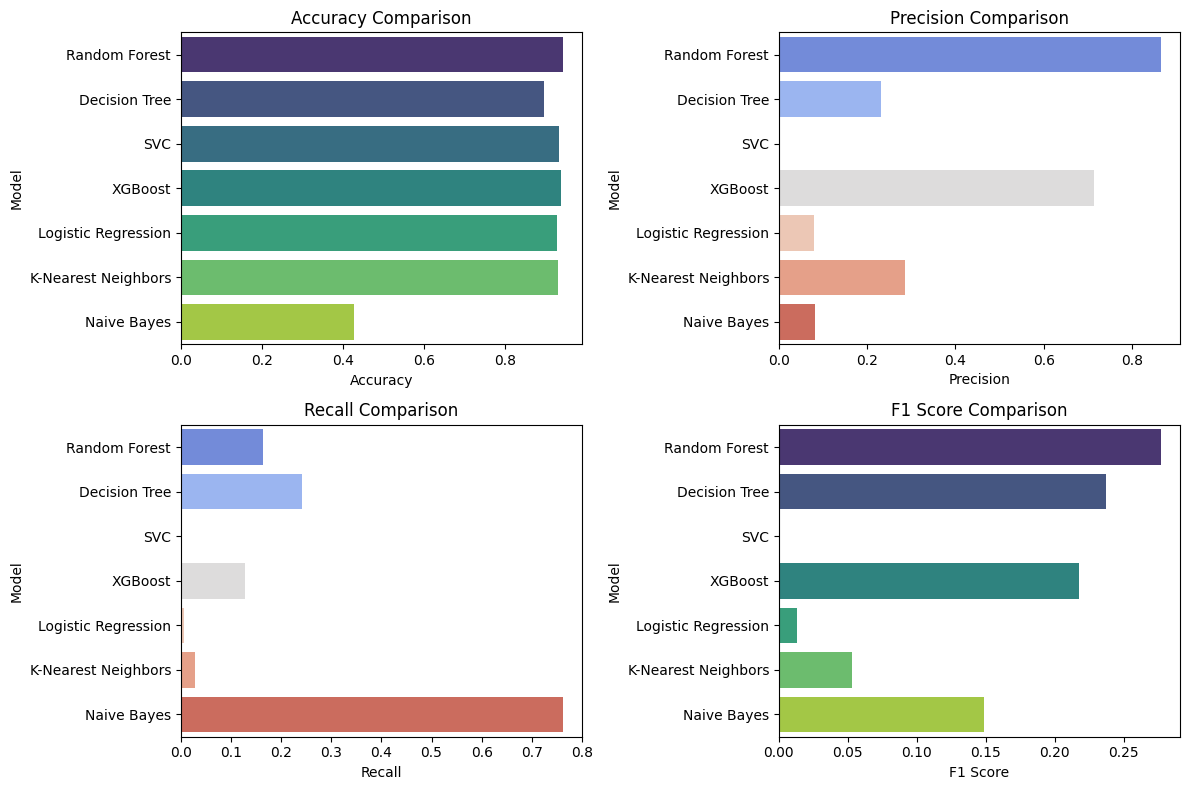

C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\4107831651.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC-ROC', y='Model', data=metrics, palette='magma')


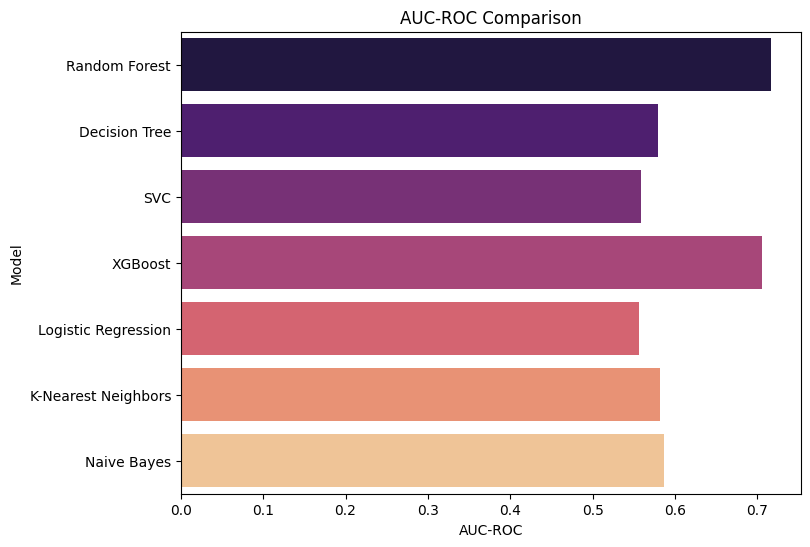

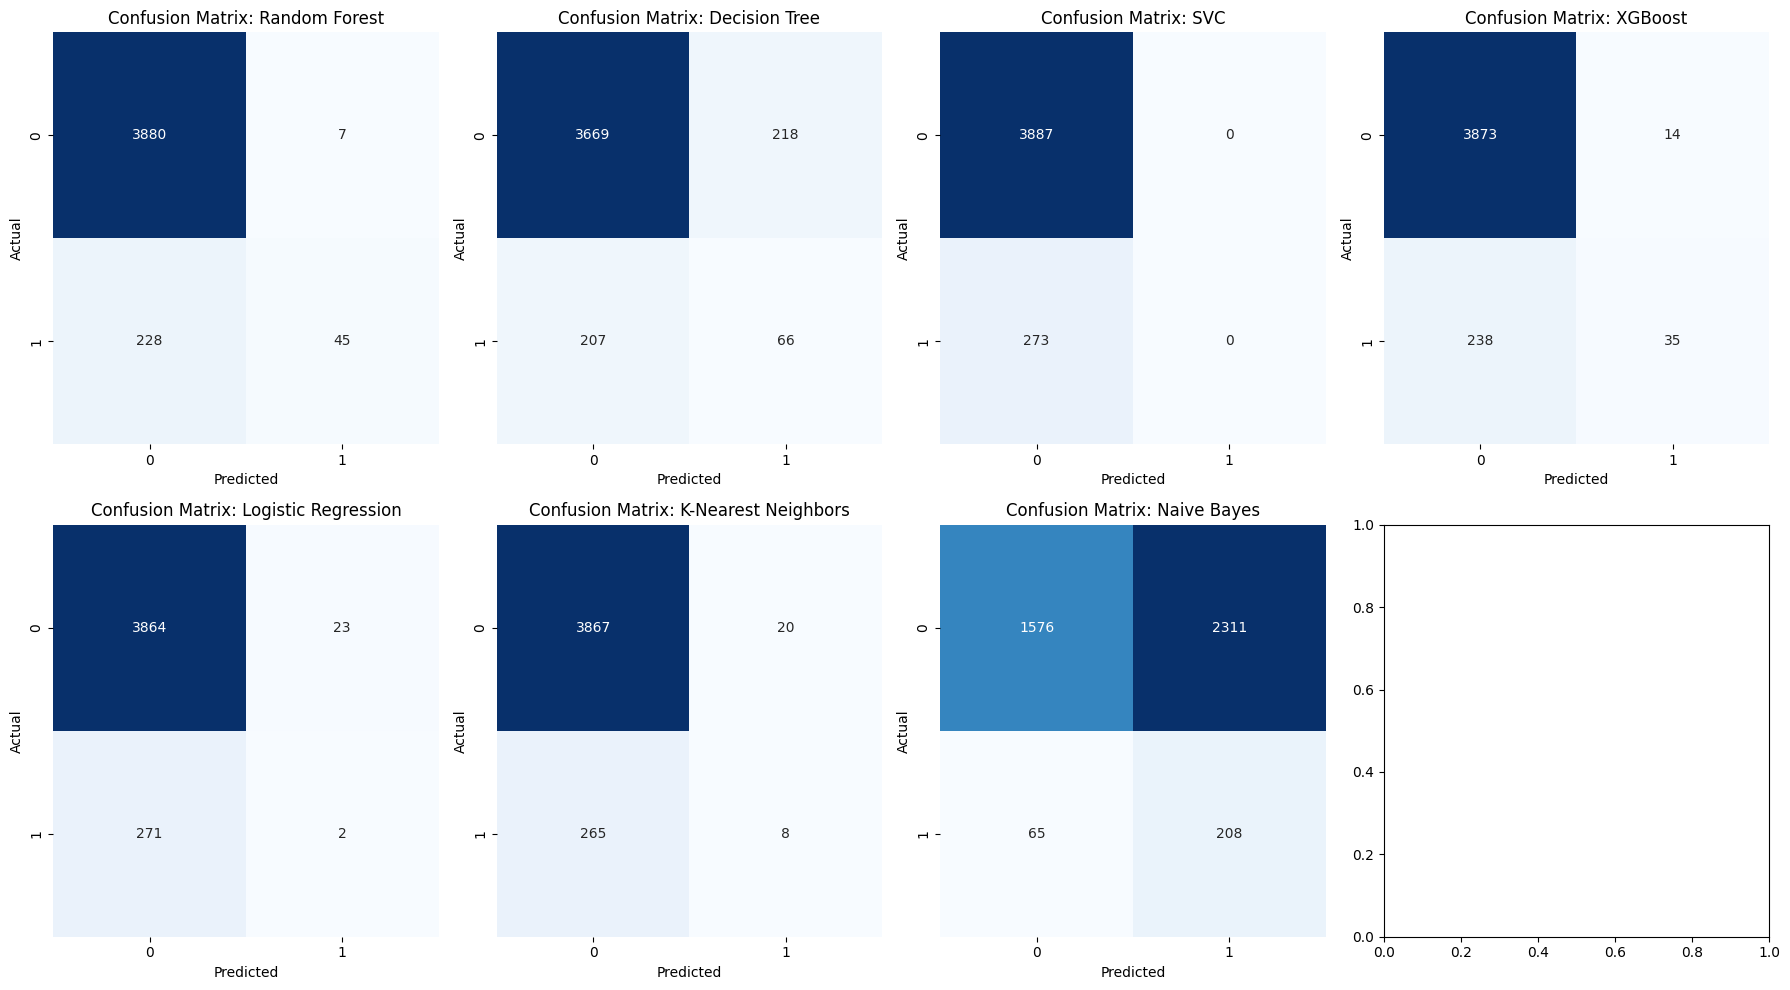

In [13]:

# Plot the metrics comparison
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=metrics, palette='viridis')
plt.title('Accuracy Comparison')

# Plot Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Precision', y='Model', data=metrics, palette='coolwarm')
plt.title('Precision Comparison')

# Plot Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Recall', y='Model', data=metrics, palette='coolwarm')
plt.title('Recall Comparison')

# Plot F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x='F1 Score', y='Model', data=metrics, palette='viridis')
plt.title('F1 Score Comparison')

plt.tight_layout()
plt.show()

# Plot AUC-ROC Comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='AUC-ROC', y='Model', data=metrics, palette='magma')
plt.title('AUC-ROC Comparison')
plt.show()

# Plot Confusion Matrices for each model
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\2806410109.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Precision', y='Model', data=metrics, palette='viridis')


Text(0.5, 1.0, 'Precision Comparison')

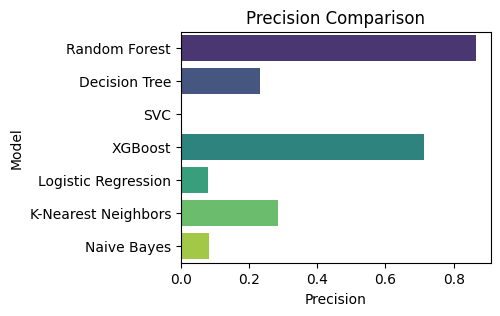

In [21]:
# Plot Precision
plt.figure(figsize=(4, 3))
sns.barplot(x='Precision', y='Model', data=metrics, palette='viridis')
plt.title('Precision Comparison')
 

C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\3200187441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=metrics, palette='viridis')


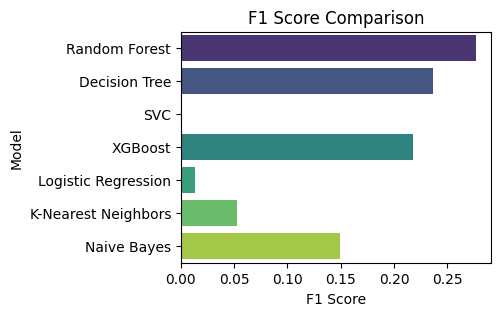

In [22]:

# Plot F1 Score
plt.figure(figsize=(4, 3))
sns.barplot(x='F1 Score', y='Model', data=metrics, palette='viridis')
plt.title('F1 Score Comparison')
plt.show()


C:\Users\1G6652897\AppData\Local\Temp\ipykernel_15732\4102792525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC-ROC', y='Model', data=metrics, palette='magma')


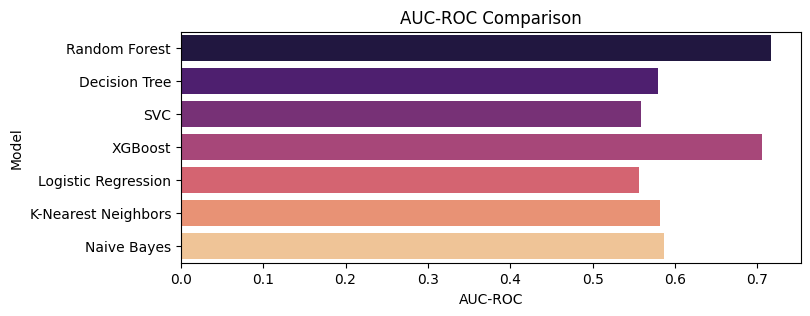